In [25]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend
import tensorflow.keras.layers
import tensorflow.keras.models
import time
import sys
import os

In [27]:
data_train = pd.read_csv('/content/drive/MyDrive/lish-moa/train_features.csv')
data_test = pd.read_csv('/content/drive/MyDrive/lish-moa/test_features.csv')
targetns = pd.read_csv('/content/drive/MyDrive/lish-moa/train_targets_nonscored.csv')
targetscored = pd.read_csv('/content/drive/MyDrive/lish-moa/train_targets_scored.csv')
sub = pd.read_csv('/content/drive/MyDrive/lish-moa/sample_submission.csv')

In [28]:
target_cols = targetscored.columns[1:]
# N_TARGETS = len(target_cols)
print(data_train.shape)
print(data_test.shape)
print(targetns.shape)
print(targetscored.shape)

(23814, 876)
(3982, 876)
(23814, 403)
(23814, 207)


In [29]:
cells = [col for col in data_train.columns if col.startswith('c-')]
genes = [col for col in data_train.columns if col.startswith('g-')]

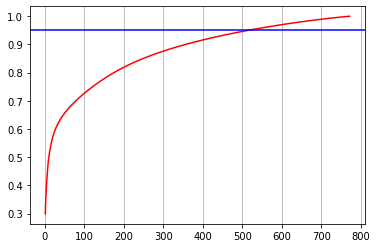

In [30]:
#Deciding the number of components for gene features
data = pd.concat([pd.DataFrame(data_train[genes]), pd.DataFrame(data_test[genes])])
pca = PCA().fit(data)
xi = np.arange(1, 773, 1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, y, color = 'red')
plt.axhline(y = 0.95, color = 'blue')
plt.grid(axis = 'x')

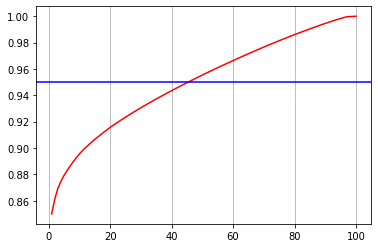

In [31]:
#Deciding the number of components for cell features
data = pd.concat([pd.DataFrame(data_train[cells]), pd.DataFrame(data_test[cells])])
pca = PCA().fit(data)
xi = np.arange(1, 101, 1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, y, color = 'red')
plt.axhline(y = 0.95, color = 'blue')
plt.grid(axis = 'x')

In [32]:
# For g- features
data = pd.concat([pd.DataFrame(data_train[genes]), pd.DataFrame(data_test[genes])])
data_pca = (PCA(n_components = 525, random_state = 100).fit_transform(data[genes]))
train_pca = data_pca[:data_train.shape[0]]
test_pca = data_pca[-data_test.shape[0]:]

train_pca = pd.DataFrame(train_pca, columns = [f'pca_G-{i}' for i in range(525)])
test_pca = pd.DataFrame(test_pca, columns = [f'pca_G-{i}' for i in range(525)])

data_train = pd.concat((data_train, train_pca), axis = 1)
data_test = pd.concat((data_test, test_pca), axis = 1)

In [33]:
# For c- features
data = pd.concat([pd.DataFrame(data_train[cells]), pd.DataFrame(data_test[cells])])
data_pca = (PCA(n_components = 45, random_state = 100).fit_transform(data[cells]))
train_pca = data_pca[:data_train.shape[0]]
test_pca = data_pca[-data_test.shape[0]:]

train_pca = pd.DataFrame(train_pca, columns = [f'pca_C-{i}' for i in range(45)])
test_pca = pd.DataFrame(test_pca, columns = [f'pca_C-{i}' for i in range(45)])
data_train = pd.concat((data_train, train_pca), axis = 1)
data_test = pd.concat((data_test, test_pca), axis = 1)
# data_train

In [34]:
train_copy = data_train
var_thresh = VarianceThreshold(0.8)
data = data_train.append(data_test)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])
data_transformed.shape

(27796, 1022)

In [35]:
train_df_trans = data_transformed[ : data_train.shape[0]]
test_df_trans = data_transformed[-data_test.shape[0] : ]

data_train = pd.DataFrame(data_train[['sig_id', 'cp_type', 'cp_time', 'cp_dose']].
                        values.reshape(-1, 4), columns = ['sig_id', 'cp_type', 
                                                          'cp_time', 'cp_dose'])
# data_train.head
data_train = pd.concat([data_train, pd.DataFrame(train_df_trans)], axis = 1)


data_test = pd.DataFrame(data_test[['sig_id', 'cp_type', 'cp_time', 'cp_dose']].
                       values.reshape(-1, 4), columns = ['sig_id', 'cp_type', 
                                                         'cp_time', 'cp_dose'])
# data_train.head
data_test = pd.concat([data_test, pd.DataFrame(test_df_trans)], axis = 1)
# data_train.head

In [37]:
def preprocess_df(data):
  # data['cp_type'] = (data['cp_type'] == 'trt_cp').astype(int)
  # data['cp_dose'] = (data['cp_dose'] == 'D2').astype(int)
  data.drop(['cp_type'], axis = 1, inplace = True)
  data.loc[:, 'cp_dose'] = data.loc[:, 'cp_dose'].map({'D1':0, 'D2':1})
  data.loc[:, 'cp_time'] = data.loc[:, 'cp_time'].map({24:0, 48:1, 72:2})
  return data

In [38]:
x_train = preprocess_df(data_train.drop(columns = "sig_id"))
x_test = preprocess_df(data_test.drop(columns = "sig_id"))
y_train = targetscored.drop(columns = "sig_id")
y_test = targetns.drop(columns = "sig_id")
print(y_test.shape)
N_FEATURES = x_train.shape[1]

(23814, 402)


In [39]:
x_train = x_train.astype({'cp_time':int})
x_test = x_test.astype({'cp_time':int})
x_train_validation = x_train.copy()
# x_train

In [40]:
def create_model(col_num):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(col_num))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(6144, 
                                                                 activation = "relu")))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(6144, 
                                                                 activation = "relu")))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, 
                                                                 activation = "sigmoid")))
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005), 
                loss = 'binary_crossentropy', metrics = ["accuracy"])
  return model

In [44]:
def build_train(repeat_number = 0, folds = 5):
  models = []
  predicted_values = y_train.copy()
  kfold = KFold(n_splits = folds, shuffle = True)
  for fold, (ti, vi) in enumerate(kfold.split(x_train)):
    print('Training fold: ', fold)
    model_save = f'model:{repeat_number}_{fold}.hdf5'
    callback_1 = tf.keras.callbacks.ModelCheckpoint(model_save, 
                                                    monitor = 'val_loss', 
                                                    verbose = 2,
                                                    save_best_only = True, 
                                                    save_weights_only = True, 
                                                    mode = 'min')
    
    callback_2 = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                          factor = 0.4, 
                                                          patience = 2, 
                                                          verbose = 1, 
                                                          min_delta = 0.0001, 
                                                          mode = 'auto')   
    
    # callback_3 = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
    #                                               verbose = 2, mode = 'max', 
    #                                               min_delta = 0.01)

    model = create_model(N_FEATURES)
    training_history = model.fit(x_train.values[ti], 
                                 y_train.values[ti], 
              validation_data = (x_train.values[vi], y_train.values[vi]),
              callbacks = [callback_1, callback_2], epochs = 25, 
              batch_size = 128, verbose = 2)
    model.load_weights(model_save)
    predicted_values.loc[vi, :] = model.predict(x_train.values[vi])
    models.append(model)
    print('train:')
    print(list(zip(model.metrics_names, model.evaluate(x_train.values[ti], 
                                                       y_train.values[ti], 
                                                       verbose = 0, 
                                                       batch_size = 32))))
    print('val:')
    print(list(zip(model.metrics_names, model.evaluate(x_train.values[vi], 
                                                       y_train.values[vi], 
                                                       verbose = 0, 
                                                       batch_size = 32))))
    return models, predicted_values, training_history
  

In [42]:
model = create_model(col_num = N_FEATURES)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
weight_normalization (Weight (None, 6144)              12601345  
_________________________________________________________________
batch_normalization_1 (Batch (None, 6144)              24576     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6144)              0         
_________________________________________________________________
weight_normalization_1 (Weig (None, 6144)              75515905  
_________________________________________________________________
batch_normalization_2 (Batch (None, 6144)              2

In [ ]:
models = []
all_predicted = []
np.random.seed(11)
os.environ['PYTHONHASHSEED'] = str(11)
tf.random.set_seed(SEED)
# SEED_ARRAY = [0, 1, 2, 3, 4]
for i in range(5):
  m_temp, pred_new, history = build_train(repeat_number = i, folds = FOLDS)  
  all_predicted.append(pred_new)
  models = models + m_temp

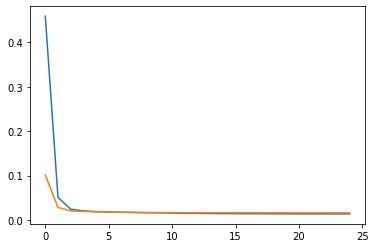

In [26]:
history.history['loss']
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

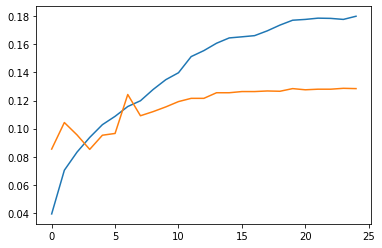

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [28]:
def new_log_loss(y_tr, y_pr):
  y_tr = y_tr.astype(np.float16)
  y_pr = y_pr.astype(np.float16)
  N, M = y_pr.shape
  loss = []

  for m in range(M):
    loss_temp = 0
    for i in range(N):
      loss_temp -= ((y_tr[i,m]*np.log(y_pr[i,m]))+((1.0-y_tr[i,m])*np.log(1.0-y_pr[i,m])))
    loss_temp = loss_temp/N
    loss.append(loss_temp)
    cleaned_loss = [l for l in loss if str(l) != 'nan']
  return np.mean(cleaned_loss)


In [29]:
log_loss = 0.0
count = 0
y_tr_temp = y_train.to_numpy()
for model in models:
  y_pred = model.predict(x_train)
  log_loss = log_loss + new_log_loss(y_tr_temp, y_pred)
  count = count + 1
print("Log loss: ", str(log_loss/count))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in half_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in half_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # 

Log loss:  0.020528204359036326
